In [2]:

# SHIFT-BY-WIRE FAULT DETECTION SYSTEM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import shap
from lime import lime_tabular
import warnings
warnings.filterwarnings("ignore")


In [11]:
#synthetic sensor data


np.random.seed(42)
time = np.arange(0, 300, 0.1)
gear = np.repeat(np.arange(1,7), len(time)//6)
gear = np.pad(gear, (0, len(time)-len(gear)), 'edge')

torque_demand = 200 + 50*np.sin(0.05*time) + np.random.normal(0, 5, len(time)) #what the driver actually applies or desires
torque_actual = torque_demand.copy() # what actually is provided
delay_points = np.random.choice(len(time), 40, replace=False)
torque_actual[delay_points] -= np.random.uniform(30, 80, len(delay_points))
torque_actual += np.random.normal(0, 5, len(time))
actuator_pos = np.interp(torque_demand, (torque_demand.min(), torque_demand.max()), (0,100)) #position of actuator
actuator_pos += np.random.normal(0, 3, len(time))
clutch_pressure = 10 + 3*np.sin(0.03*time + 1) + np.random.normal(0,0.3,len(time)) #clutch pressure

df = pd.DataFrame({
    'time_s': time,
    'gear': gear,
    'torque_demand': torque_demand,
    'torque_actual': torque_actual,
    'actuator_pos': actuator_pos,
    'clutch_pressure': clutch_pressure
})

df.to_csv('synthetic_sensor_data.csv', index=False)



In [4]:

# 2. Feature Engineering

df['torque_error'] = df['torque_demand'] - df['torque_actual']
df['torque_rate'] = df['torque_actual'].diff() / df['time_s'].diff()
df['pressure_rate'] = df['clutch_pressure'].diff() / df['time_s'].diff()
df = df.fillna(0)

df['torque_error_rm'] = df['torque_error'].rolling(5).mean().fillna(0)
df['torque_rate_rm'] = df['torque_rate'].rolling(5).mean().fillna(0)

features = ['torque_error_rm','torque_rate_rm','pressure_rate','actuator_pos']
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




In [5]:
model = IsolationForest(contamination=0.05, random_state=42)
df['fault_flag'] = model.fit_predict(X_scaled)
faults = df[df['fault_flag'] == -1]



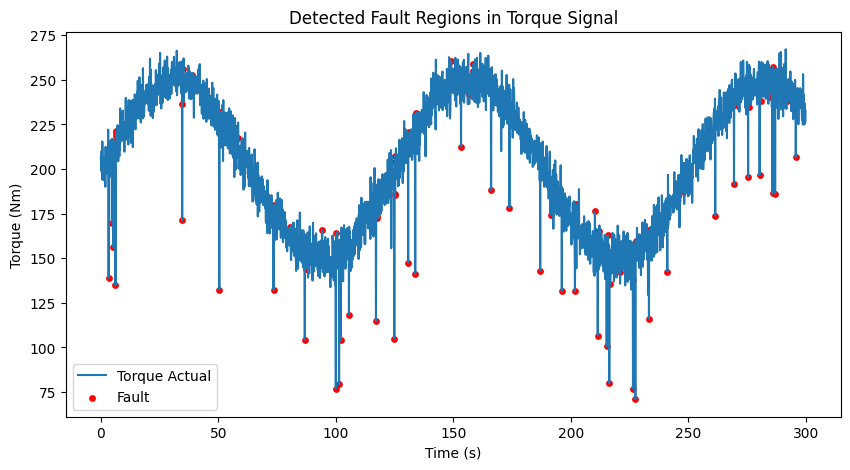

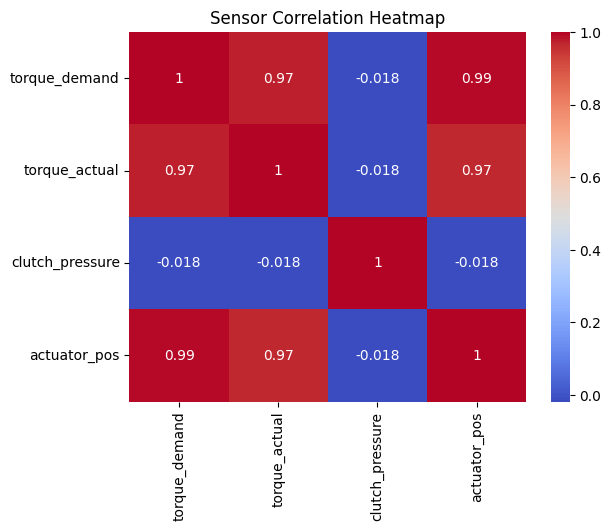

In [6]:

# Visualization

plt.figure(figsize=(10,5))
plt.plot(df['time_s'], df['torque_actual'], label='Torque Actual')
plt.scatter(faults['time_s'], faults['torque_actual'], color='r', s=15, label='Fault')
plt.legend()
plt.title("Detected Fault Regions in Torque Signal")
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.show()

sns.heatmap(df[['torque_demand','torque_actual','clutch_pressure','actuator_pos']].corr(), annot=True, cmap='coolwarm')
plt.title("Sensor Correlation Heatmap")
plt.show()



Running SHAP explainability...


 99%|===================| 2967/3000 [00:30<00:00]       

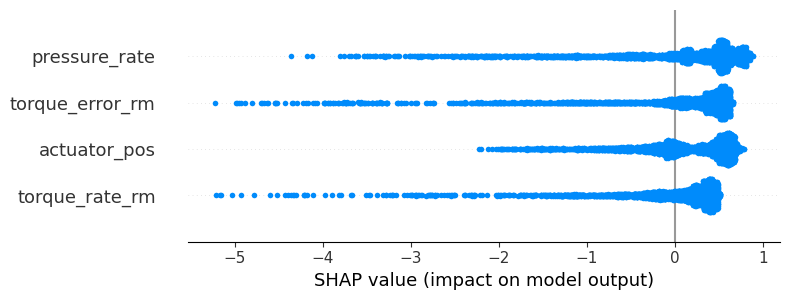

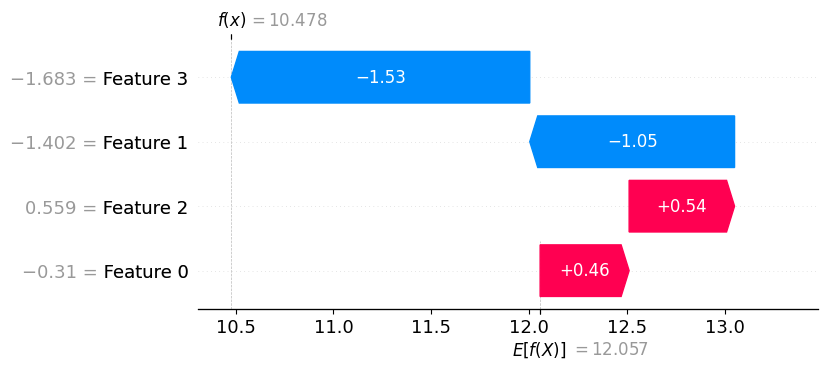

In [7]:

#Explainability with SHAP

print("Running SHAP explainability...")
explainer = shap.Explainer(model, X_scaled)
shap_values = explainer(X_scaled)

# Global feature importance
shap.summary_plot(shap_values, features=features, show=True)

# Example local explanation (single sample)
sample_idx = np.random.randint(0, len(df))
shap.plots.waterfall(shap_values[sample_idx], max_display=5)



In [8]:

# 6. Explainability with LIME
print("Running LIME explainability...")
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=features,
    mode='classification'
)

# LIME requires a prediction function returning probabilities
def predict_proba_lime(X_test):
    preds = model.decision_function(X_test)
    # convert to pseudo-probabilities
    probs = (preds - preds.min()) / (preds.max() - preds.min())
    probs = np.vstack([1-probs, probs]).T
    return probs

instance = X_scaled[sample_idx]
lime_exp = lime_explainer.explain_instance(instance, predict_proba_lime, num_features=4)
lime_exp.show_in_notebook(show_table=True)



Running LIME explainability...


In [9]:

# 7. KPI Summary

print("\nFault Summary:")
print(f"Total samples: {len(df)}")
print(f"Detected faults: {len(faults)}")
print("\nExample feature importance from SHAP and LIME complete ✅")


Fault Summary:
Total samples: 3000
Detected faults: 150

Example feature importance from SHAP and LIME complete ✅


In [2]:
pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=34925d125bba130f5f28d0bb1d071bf2e6107b8c27ce66135e6a2749534c80b8
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
